In [49]:
import torch
import matplotlib.pyplot as plt
import os

from torchvision.datasets import CIFAR10

In [50]:
data_dir = '/Python310/DL_PyTorch'
CATEGORIES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [51]:
cifar10_train = CIFAR10(data_dir, train=True, download=True)
cifar10_test = CIFAR10(data_dir, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [52]:
(len(cifar10_train), len(cifar10_test))

(50000, 10000)

In [53]:
def lookat_dataset(dataset, istensor=False):
    figure = plt.figure(figsize=(8, 8))
    rows, cols = 2, 2
    for i in range(1, 5):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(CATEGORIES[label])
        plt.axis("off")
        if istensor:
            plt.imshow(img.squeeze().permute(1, 2, 0))
        else:
            plt.imshow(img)
    plt.show()

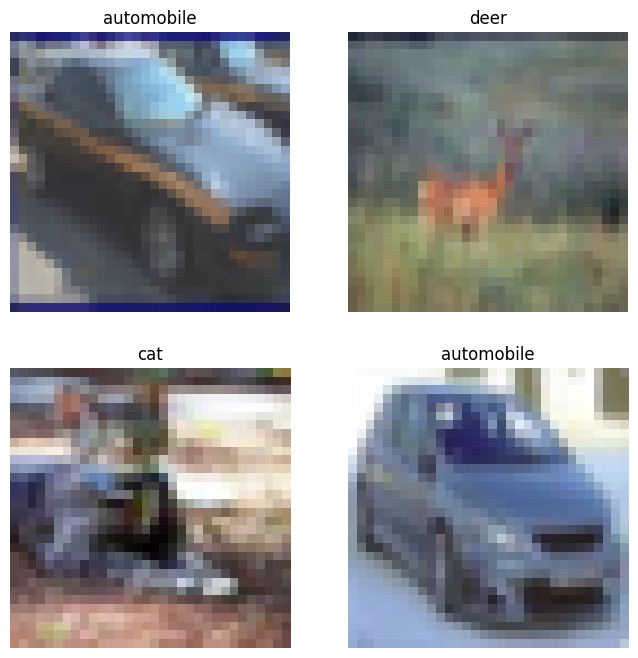

In [54]:
lookat_dataset(cifar10_train)

pre processando os dados

In [55]:
import torchvision.transforms as T

In [56]:
prep_transform = T.Compose(
[
    T.ToTensor(),
    T.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2470, 0.2435, 0.2616)
    )
]
)

tensor_train = CIFAR10(data_dir, train=True, download=False,
                       transform=prep_transform)
tensor_test = CIFAR10(data_dir, train=False, download=False,
                      transform = prep_transform)

In [57]:
imgs = torch.stack([img_t for img_t, _ in tensor_train], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [58]:
imgs.view(3, -1).mean(dim=1)

tensor([-1.2762e-06, -1.7074e-04,  1.1819e-04])

In [59]:
imgs.view(3, -1).std(dim=1)

tensor([1.0001, 0.9999, 1.0000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


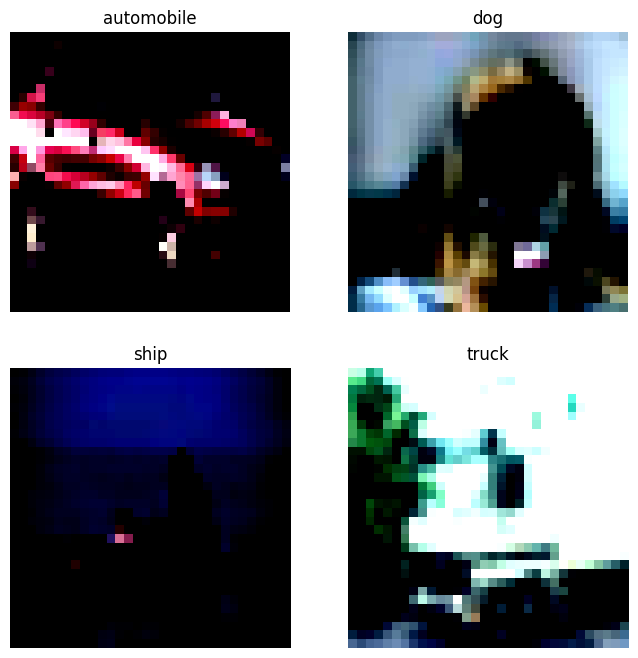

In [60]:
lookat_dataset(tensor_train, True)

criando dataloaders

In [61]:
from torch.utils.data import DataLoader

In [62]:
batch_size = 64
train_loader = DataLoader(tensor_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tensor_test, batch_size=batch_size, shuffle=True)

Construindo uma rede MLP

In [63]:
from torch import nn

In [64]:
class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten() # permite interpretar um tensor com n dimensões em um vetor com uma dimensão. Permite interpretar minha imagem como um vetor

        self.layers = nn.Sequential(
            nn.Linear(32*32*3,256), #temos 32 pixels por 32 pixels, porem ainda temos RGB, 3 valores.
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),         # ReLU é a função de ativação mais amplamente utilizada ao projetar redes neurais atualmente.
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10), #saida temos 10 classes, por isso fecha com 10

        )
    
    def forward(self, x): # x é a entrada da imagem
        v = self.flatten(x)  # vetoriza a imagem / "planifica"
        return self.layers(v) # passo o vetor pelas camadas da rede neural, sentido pra frente.

In [65]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cpu


In [66]:
model = MLPClassifier().to(device)

Escolhendo Hiperparametros de Otimização

In [67]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)  #otimizador Stochastic Gradient Descent (Gradienet descendente Estocastico)
lossfunc = nn.CrossEntropyLoss() #Loss Function, Função de Perda Cross Entropy mede a eficiencia da classificação, no caso Entropia Cruzada.

In [68]:
def train(mode, dataloader, lossfunc, optimizer):
    model.train()
    cumloss = 0.0
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)

        pred = model(imgs)
        loss = lossfunc(pred, labels)

        # zera os gradientes acumulados
        optimizer.zero_grad()
        # computa os gradientes
        loss.backward()
        # anda, de fato, na direção que reduz o erro local
        optimizer.step()

        # loss é um tensor: item pra obter o float
        cumloss += loss.item()

    return cumloss / len(dataloader)

def validate(model, dataloader, loss_func):
    model.eval()
    cumloss=0.0

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)

            pred = model(imgs)
            loss = loss_func(pred, labels)
            cumloss += loss.item()
    return cumloss / len(dataloader)

In [80]:
import matplotlib.pyplot as plt

def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for loss_name, loss_values in losses.items():
        ax.plot(loss_values, label=loss_name)
    ax.legend(fontsize="16")
    ax.set_title("Loss vs iterations", fontsize=16)

In [73]:
epochs = 31
train_losses = []
test_losses = []
for t in range(epochs):
    train_loss = train(model, train_loader, lossfunc, optimizer)
    if t% 10 == 0:
        print(f"Epoch: {t}; Train Loss: {train_loss}")
    test_loss = validate(model, test_loader, lossfunc)
    test_losses.append(test_loss)

Epoch: 0; Train Loss: 1.4717430066879449
Epoch: 10; Train Loss: 1.3694426527108683
Epoch: 20; Train Loss: 1.2789155915570076
Epoch: 30; Train Loss: 1.1929920803555443


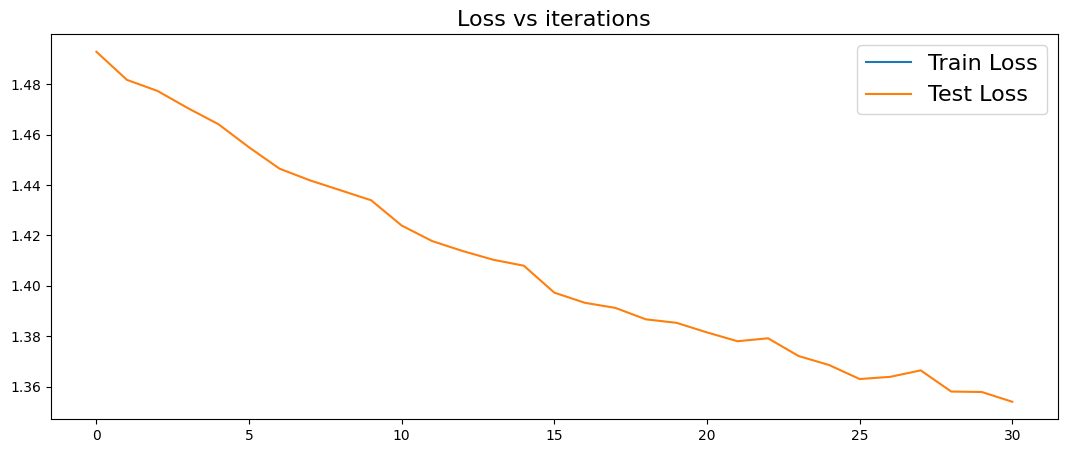

In [81]:
losses = {"Train Loss": train_losses, "Test Loss": test_losses}
plot_losses(losses)